In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.pandas.set_option("display.max_rows",None)
pd.pandas.set_option("display.max_columns",None)

In [3]:
df=pd.read_csv('../input/life-expectancy-who/Life Expectancy Data.csv')

In [4]:
df.head(5) 

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [5]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

We need to remove white spaces from feature names otherwise this can make output ambiguous 

In [6]:
df.rename(columns={'Life expectancy ':'Life_Expectancy','Adult Mortality':'Adult_Mortality','infant deaths':'Infant_Deaths',
                   'Hepatitis B':'Hepatitis_B','percentage expenditure':'Percentage_Expenditure','Measles ':'Measles',
                   ' BMI ':'BMI','under-five deaths ':'Under-Five_Deaths','Total expenditure':'Total_Expenditure',
                  'Diphtheria ':'Diphtheria',' HIV/AIDS':'HIV_AIDS',' thinness  1-19 years':'Thinness_1-19_Years',
                  ' thinness 5-9 years':'Thinness_5-9_Years','Income composition of resources':'ICR'},inplace=True)
df.columns

Index(['Country', 'Year', 'Status', 'Life_Expectancy', 'Adult_Mortality',
       'Infant_Deaths', 'Alcohol', 'Percentage_Expenditure', 'Hepatitis_B',
       'Measles', 'BMI', 'Under-Five_Deaths', 'Polio', 'Total_Expenditure',
       'Diphtheria', 'HIV_AIDS', 'GDP', 'Population', 'Thinness_1-19_Years',
       'Thinness_5-9_Years', 'ICR', 'Schooling'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 2938 non-null   object 
 1   Year                    2938 non-null   int64  
 2   Status                  2938 non-null   object 
 3   Life_Expectancy         2928 non-null   float64
 4   Adult_Mortality         2928 non-null   float64
 5   Infant_Deaths           2938 non-null   int64  
 6   Alcohol                 2744 non-null   float64
 7   Percentage_Expenditure  2938 non-null   float64
 8   Hepatitis_B             2385 non-null   float64
 9   Measles                 2938 non-null   int64  
 10  BMI                     2904 non-null   float64
 11  Under-Five_Deaths       2938 non-null   int64  
 12  Polio                   2919 non-null   float64
 13  Total_Expenditure       2712 non-null   float64
 14  Diphtheria              2919 non-null   

In [8]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'missing_value %': percent_missing})
missing_value_df.sort_values('missing_value %',ascending=False, inplace=True)
missing_value_df

,missing_value %
Population,22.191967
Hepatitis_B,18.822328
GDP,15.248468
Total_Expenditure,7.692308
Alcohol,6.603131
ICR,5.684139
Schooling,5.547992
Thinness_5-9_Years,1.157250
Thinness_1-19_Years,1.157250
BMI,1.157250


In [9]:
percent_missing = (df == 0).astype(int).sum(axis=0) * 100 / len(df)
zero_value_df = pd.DataFrame({'Zero_value %': percent_missing})
zero_value_df.sort_values('Zero_value %',ascending=False, inplace=True)
zero_value_df

,Zero_value %
Measles,33.458135
Infant_Deaths,28.863172
Under-Five_Deaths,26.718856
Percentage_Expenditure,20.796460
ICR,4.424779
Schooling,0.953029
Alcohol,0.000000
Adult_Mortality,0.000000
Hepatitis_B,0.000000
Life_Expectancy,0.000000


<AxesSubplot:>

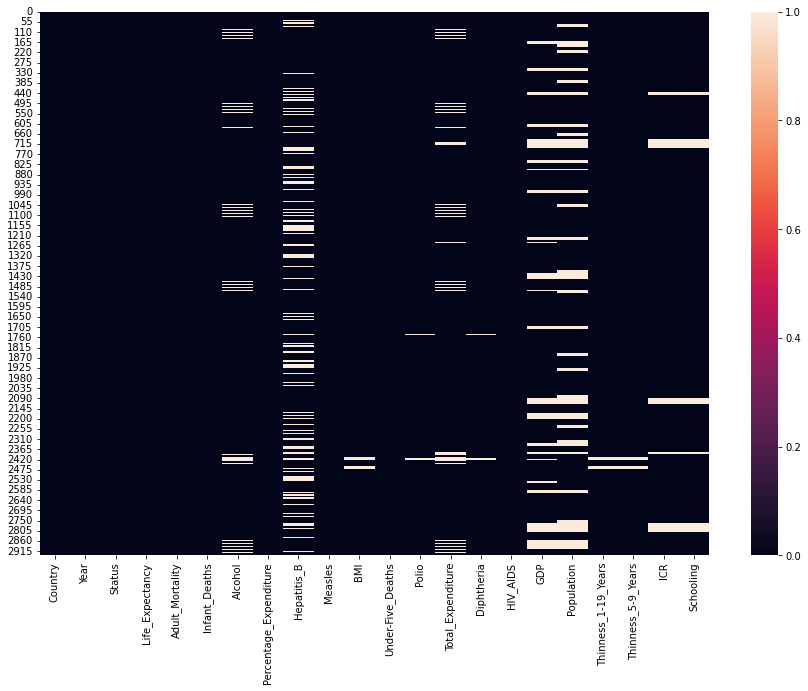

In [10]:
plt.figure(figsize=(15,10))
sns.heatmap(df.isnull())

before applying correlation we need to check skewness and kurtosis of data<br>


skewness == 0 : normally distributed , can use pearson correation (assuming homogeneity exist)<br>
skewness > 0 : more weight in the left tail of the distribution<br>
skewness < 0 : more weight in the right tail of the distribution<br>

if skewness != 0 we use 
1. kendall : Tau correlation coefficient
2. spearman : Rank correlation

Skewness differentiates extreme values in one versus the other tail <br>
Kurtosis measures extreme values in either tail. <br>

Large kurtsis (+ve/-ve) : five or more standard deviations from the mean , tail data exceeds normal distribution <br>
Low kurtosis : skinny , less extreme than tails of normal distribution


In [11]:
stats = df.describe()
stats.loc['median'] = df.median().tolist()
stats.loc['skew'] = df.skew().tolist()
stats.loc['kurt'] = df.kurtosis().tolist()
stats_df=pd.DataFrame(stats).reindex(['count','mean','std','median','50%','skew','kurt','min','max','25%','75%'])
stats_df # 50% quantile is mode

,Year,Life_Expectancy,Adult_Mortality,Infant_Deaths,Alcohol,Percentage_Expenditure,Hepatitis_B,Measles,BMI,Under-Five_Deaths,Polio,Total_Expenditure,Diphtheria,HIV_AIDS,GDP,Population,Thinness_1-19_Years,Thinness_5-9_Years,ICR,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.000000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.938190,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.498320,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
median,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.755000,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.755000,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
skew,-0.006409,-0.638605,1.174369,9.786963,0.589563,4.652051,-1.930845,9.441332,-0.219312,9.495065,-2.098053,0.618686,-2.072753,5.396112,3.206655,1.591624e+01,1.711471,1.777424,-1.143763,-0.602437
kurt,-1.213722,-0.234477,1.748860,116.042756,-0.802909,26.573387,2.770259,114.859903,-1.291095,109.752795,3.776510,1.156270,3.558143,34.892008,12.333074,2.980103e+02,3.970439,4.358730,1.392814,0.886151
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.260000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000


<AxesSubplot:>

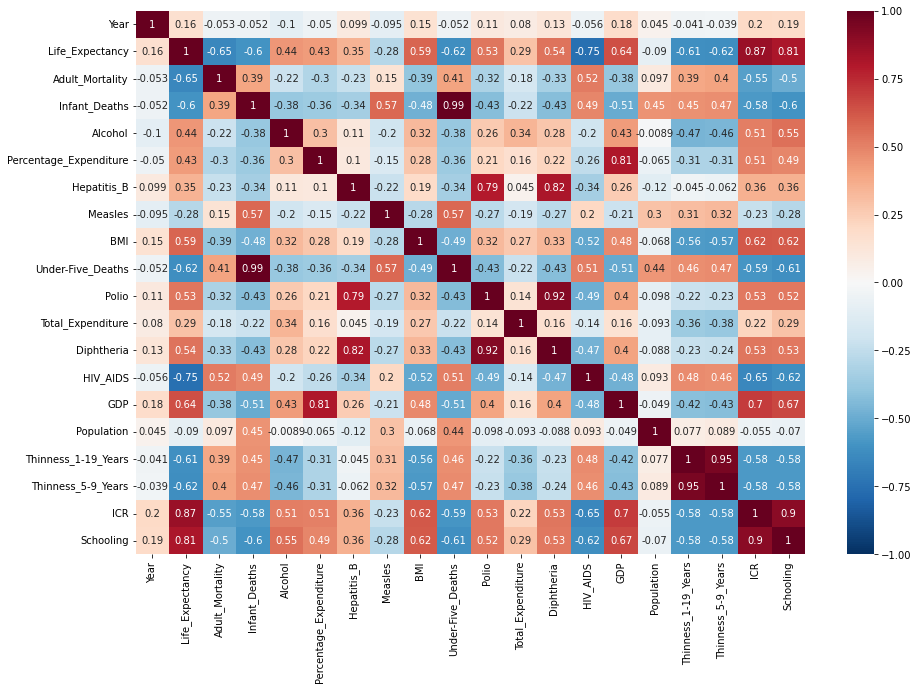

In [12]:
corr=df.corr(method='spearman',min_periods=10)
plt.figure(figsize=(15,10))
sns.heatmap(data=corr,cmap="RdBu_r",annot=True,vmin=-1,vmax=1)

<AxesSubplot:>

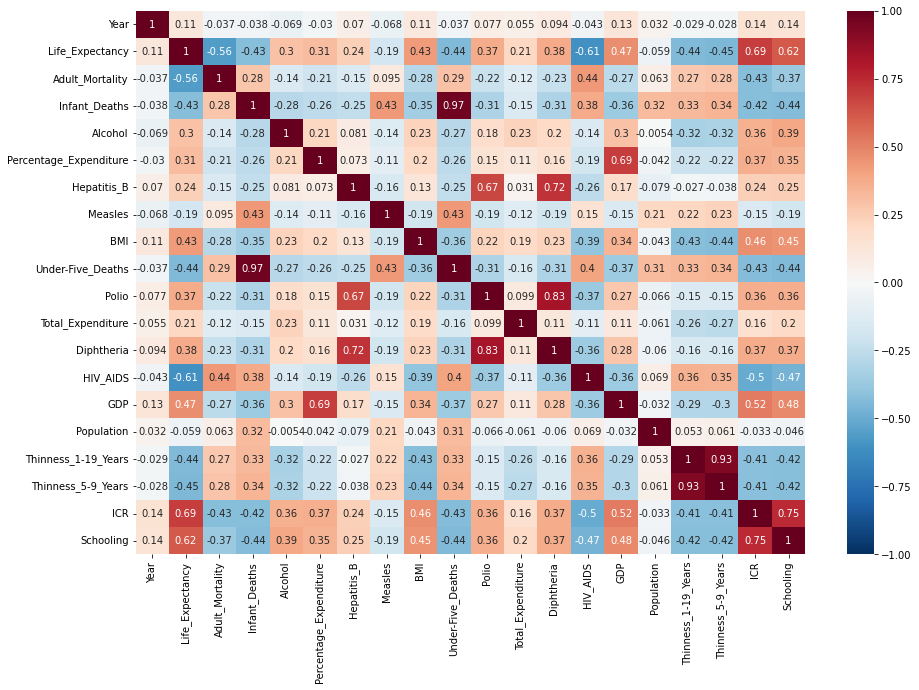

In [13]:
corr=df.corr(method='kendall')
plt.figure(figsize=(15,10))
sns.heatmap(data=corr,cmap="RdBu_r",annot=True,vmin=-1,vmax=1)

In [14]:
# plotting dendogram to get better understanding
# import scipy.cluster.hierarchy as hc
# import scipy.spatial as sp
# row_dism = 1 - df.T.corr(method='pearson')
# row_linkage = hc.linkage(sp.distance.squareform(row_dism), method='complete')
# col_dism = 1 - df.corr(method='pearson')
# col_linkage = hc.linkage(sp.distance.squareform(col_dism), method='complete')
# sns.clustermap(df,figsize=(15,10),row_linkage=row_linkage, col_linkage=col_linkage)
# plt.title('Dendogram of pearson correlation')
# plt.show()

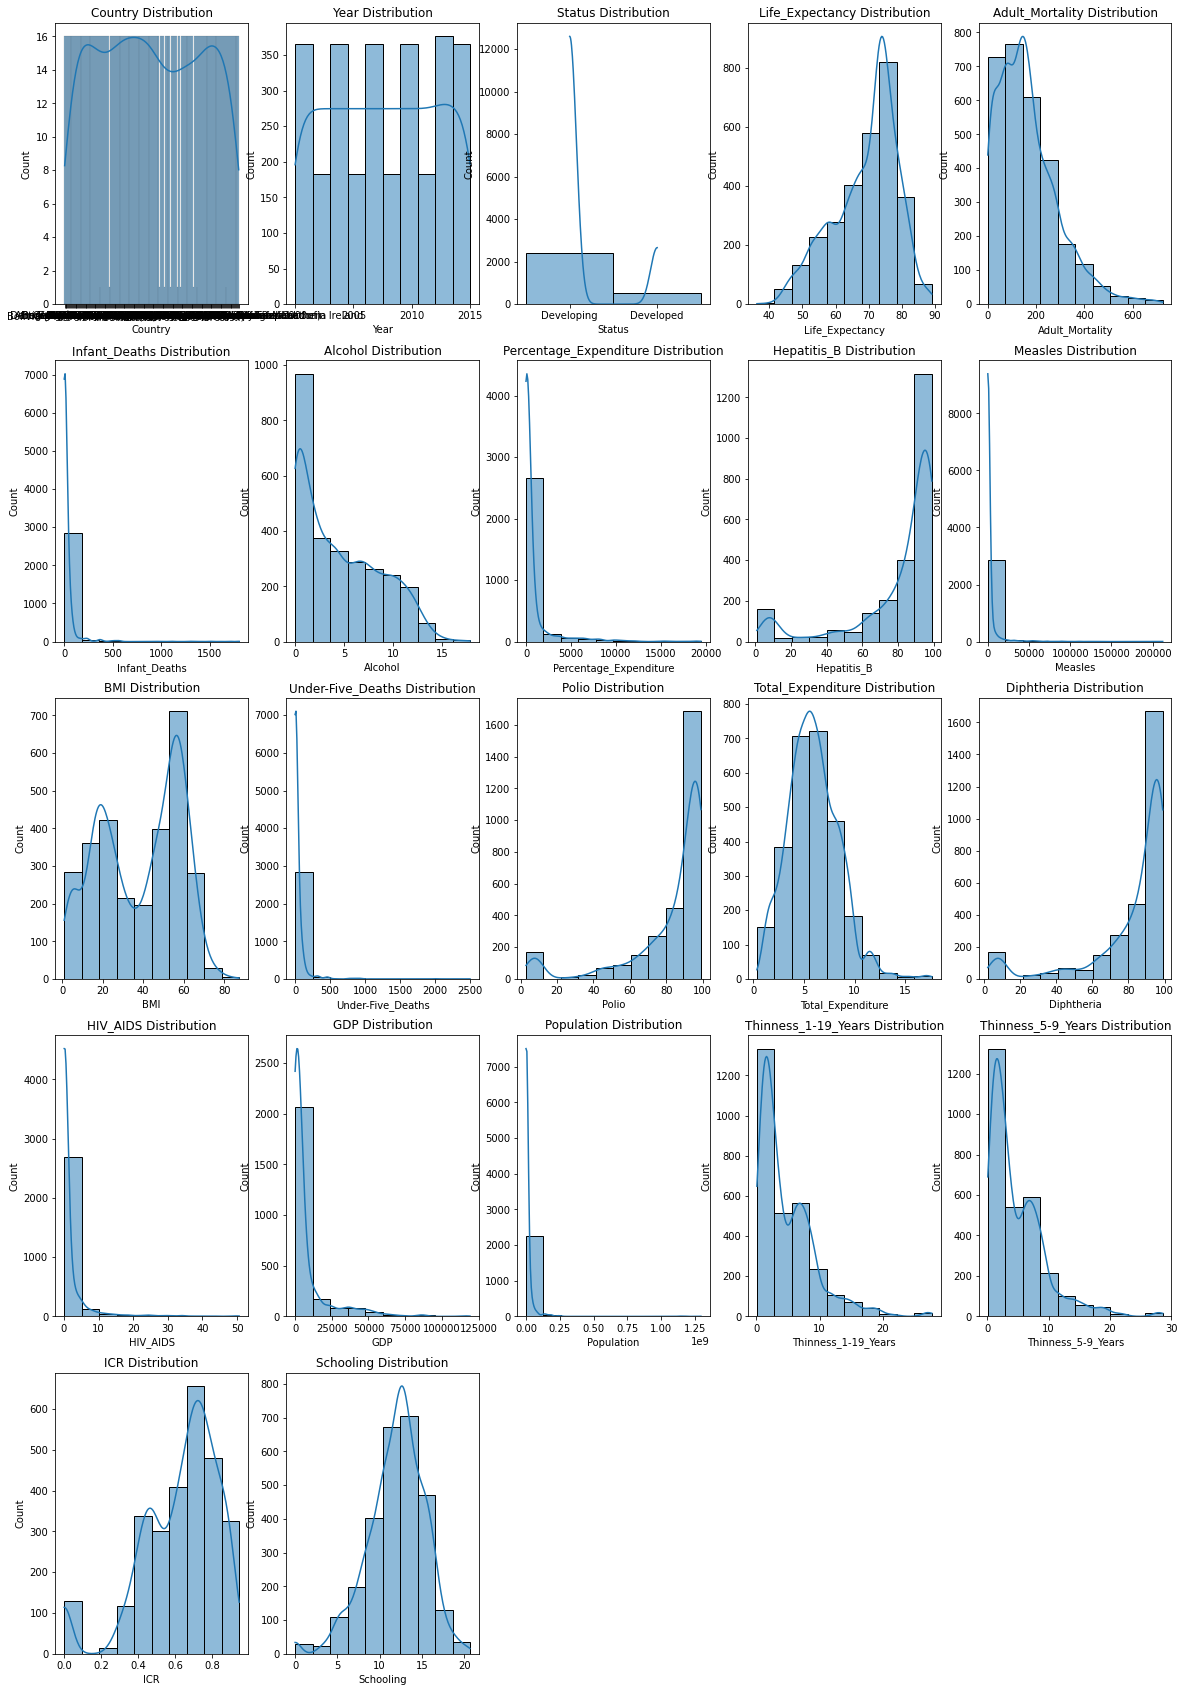

In [15]:
col_name2=['Country', 'Year', 'Status', 'Life_Expectancy', 'Adult_Mortality',
       'Infant_Deaths', 'Alcohol', 'Percentage_Expenditure', 'Hepatitis_B',
       'Measles', 'BMI', 'Under-Five_Deaths', 'Polio', 'Total_Expenditure',
       'Diphtheria', 'HIV_AIDS', 'GDP', 'Population', 'Thinness_1-19_Years',
       'Thinness_5-9_Years', 'ICR', 'Schooling']
col_dict={}
for i in range(len(col_name2)):
    col_dict[col_name2[i]]=i+1
# Detect outliers in each variable using box plots.
plt.figure(figsize=(20,30))

for key,val in col_dict.items():
    plt.subplot(5,5,val)
    sns.histplot(x=df[key],data=df,bins=10,kde=True)
    plt.xlabel(key)
    plt.title(key+' Distribution')

plt.show()

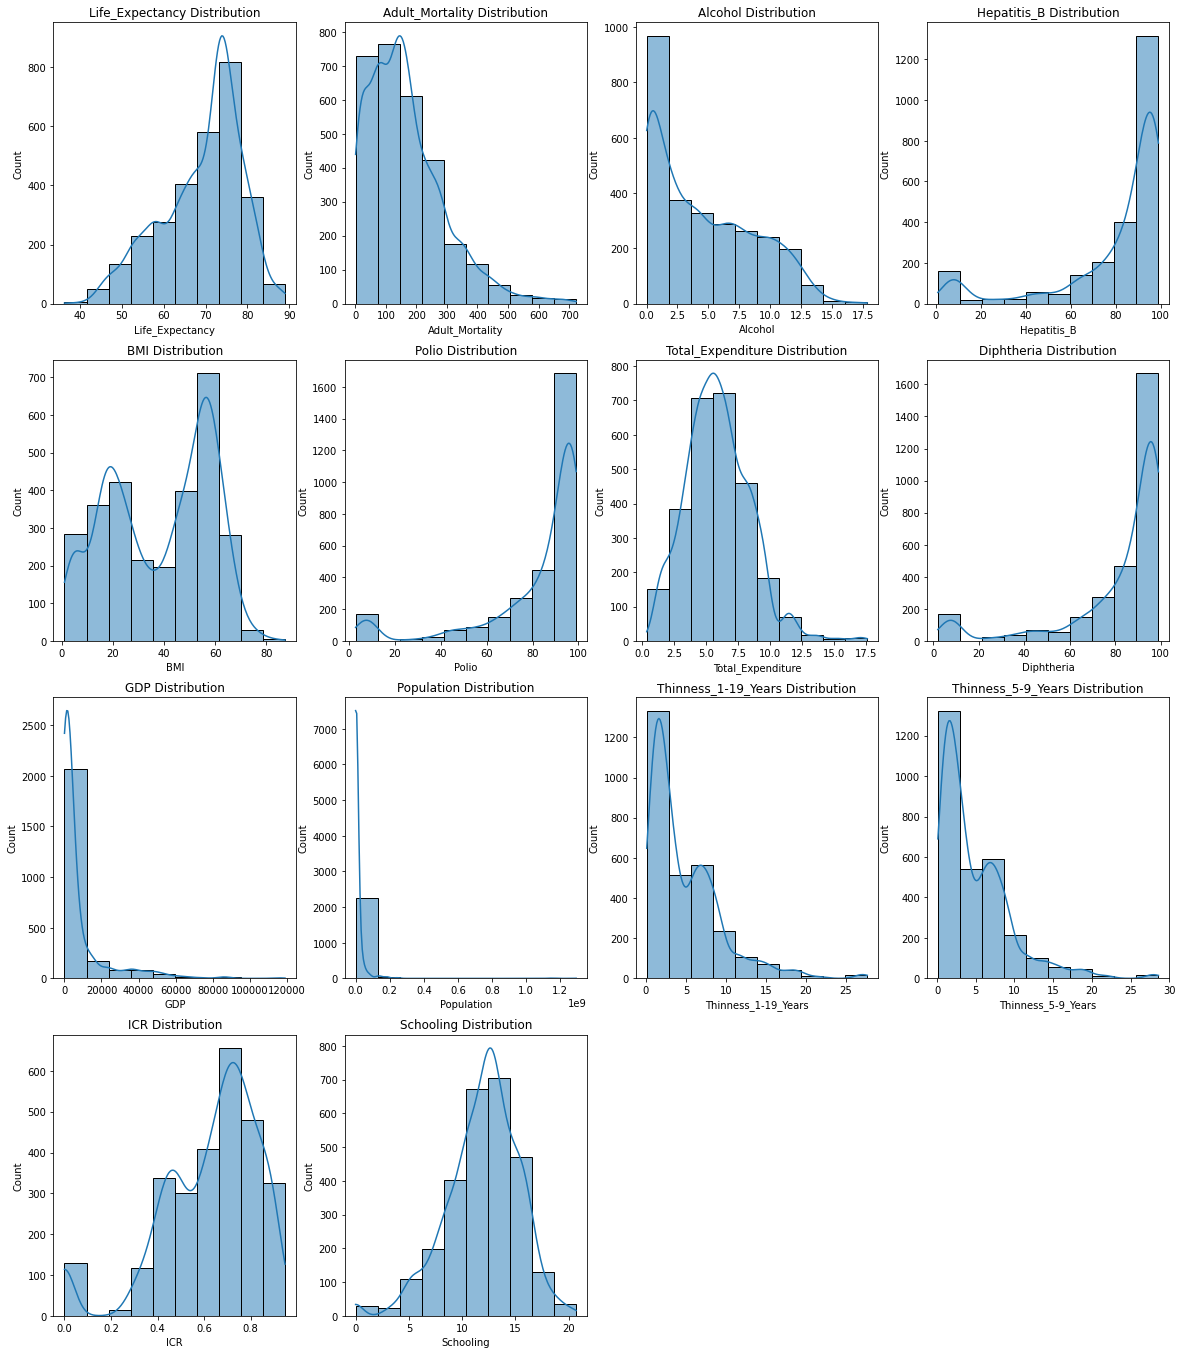

In [16]:
# Population 	22.191967
# Hepatitis_B 	18.822328
# GDP 	15.248468
# Total_Expenditure 	7.692308
# Alcohol 	6.603131
# ICR 	5.684139
# Schooling 	5.547992
# Thinness_5-9_Years 	1.157250
# Thinness_1-19_Years 	1.157250
# BMI 	1.157250
# Polio 	0.646698
# Diphtheria 	0.646698
# Life_Expectancy 	0.340368
# Adult_Mortality 	0.340368

# column - index mapping
col_name=['Life_Expectancy', 'Adult_Mortality', 'Alcohol', 'Hepatitis_B','BMI', 
        'Polio', 'Total_Expenditure','Diphtheria', 'GDP', 'Population', 'Thinness_1-19_Years',
       'Thinness_5-9_Years', 'ICR', 'Schooling']
col_dict={}
for i in range(len(col_name)):
    col_dict[col_name[i]]=i+1
# Detect outliers in each variable using box plots.
plt.figure(figsize=(20,30))

for key,val in col_dict.items():
    plt.subplot(5,4,val)
    sns.histplot(x=df[key],data=df,bins=10,kde=True)
    plt.xlabel(key)
    plt.title(key+' Distribution')

plt.show()

In [17]:
# from sklearn import preprocessing

In [18]:
# label_encoder = preprocessing.LabelEncoder()
# df['Country']= label_encoder.fit_transform(df['Country']) 
# df['Status']= label_encoder.fit_transform(df['Status']) 

using automatic null value filling by using KNN algorithm 

In [19]:
from sklearn.impute import KNNImputer

In [20]:
imputer=KNNImputer(n_neighbors=10)
df_KNN=pd.DataFrame(imputer.fit_transform(df[df.select_dtypes(include=['int64','float64']).columns]))

In [21]:
df_KNN.columns=['Year', 'Life_Expectancy', 'Adult_Mortality',
       'Infant_Deaths', 'Alcohol', 'Percentage_Expenditure', 'Hepatitis_B',
       'Measles', 'BMI', 'Under-Five_Deaths', 'Polio', 'Total_Expenditure',
       'Diphtheria', 'HIV_AIDS', 'GDP', 'Population', 'Thinness_1-19_Years',
       'Thinness_5-9_Years', 'ICR', 'Schooling']
df_KNN_std_=df_KNN[['Total_Expenditure', 'Population', 'ICR','BMI','Schooling',
                  'Life_Expectancy', 'Adult_Mortality', 'Alcohol', 'Hepatitis_B',
                    'Polio','Diphtheria', 'GDP', 'Thinness_1-19_Years',
                   'Thinness_5-9_Years']].std()
df_KNN_std_

Total_Expenditure      2.427631e+00
Population             5.474976e+07
ICR                    2.080986e-01
BMI                    1.995477e+01
Schooling              3.325084e+00
Life_Expectancy        9.511776e+00
Adult_Mortality        1.241152e+02
Alcohol                3.960926e+00
Hepatitis_B            2.322426e+01
Polio                  2.336611e+01
Diphtheria             2.365520e+01
GDP                    1.331701e+04
Thinness_1-19_Years    4.402489e+00
Thinness_5-9_Years     4.490279e+00
dtype: float64

let's try some manual null value elemination , the methods I'll be using follwing methods from 
[Krish Naik Feature Engineering](https://github.com/krishnaik06/Feature-Engineering-Live-sessions)
1. central tendency based imputation (+ randomness)
2. random sample imputation 
3. median value imputation

Population 	    -       22.191967<br>
Hepatitis_B 	  -     18.822328<br>
GDP 	         -      15.248468<br>
Total_Expenditure 	-   7.692308<br>
Alcohol 	   -        6.603131<br>
ICR 	    -           5.684139<br>
Schooling 	   -        5.547992<br>
Thinness_5-9_Years 	-   1.157250<br>
Thinness_1-19_Years -   1.157250<br>
BMI 	         -      1.157250<br>
Polio 	       -        0.646698<br>
Diphtheria 	   -        0.646698<br>
Life_Expectancy 	-   0.340368<br>
Adult_Mortality 	-   0.340368<br>

In [22]:
def central_tendency_imputer(data):
    for col in data.columns.values:
        mean_=data[col].mean()
        median_=data[col].median()
        std_=data[col].std()
        is_null_=data[col].isnull().sum()
        rand_=np.random.choice([mean_- std_,mean_ + std_,is_null_])
        data[col]=data[col].fillna(rand_)
    return data

In [23]:
def random_sample_imputer(data):
    for col in data.columns.values:
        median_=data[col].median()
        rand_s = data[col].dropna().sample(data[col].isnull().sum(),random_state=0)
        rand_s.index=data[data[col].isnull()].index
        data[col]=data[col].fillna(rand_s)
    return data

In [24]:
data_ct=df[['Total_Expenditure', 'Population', 'ICR','BMI','Schooling']]
df_CT=central_tendency_imputer(data_ct)
#df_CT=df_CT.drop(['Total_Expenditure', 'Population', 'ICR','BMI','Schooling'],axis=1)
df_CT_std_=df_CT.std()
df_CT_std_

Total_Expenditure    5.869881e+01
Population           5.407583e+07
ICR                  2.105625e-01
BMI                  2.004269e+01
Schooling            3.353745e+00
dtype: float64

In [25]:
data_rs=df[['Life_Expectancy', 'Adult_Mortality', 'Alcohol', 'Hepatitis_B',
        'Polio','Diphtheria', 'GDP', 'Thinness_1-19_Years',
       'Thinness_5-9_Years' ]]
df_RS=random_sample_imputer(data_rs)
df_RS_std_=df_RS.std()
df_RS_std_

Life_Expectancy            9.521443
Adult_Mortality          124.324827
Alcohol                    4.046275
Hepatitis_B               25.069198
Polio                     23.464716
Diphtheria                23.667401
GDP                    14189.379734
Thinness_1-19_Years        4.419409
Thinness_5-9_Years         4.507815
dtype: float64

In [26]:
df_std_=df[['Total_Expenditure', 'Population', 'ICR','BMI','Schooling',
                  'Life_Expectancy', 'Adult_Mortality', 'Alcohol', 'Hepatitis_B',
                    'Polio','Diphtheria', 'GDP', 'Thinness_1-19_Years',
                   'Thinness_5-9_Years']].std()
df_mean_=df[['Total_Expenditure', 'Population', 'ICR','BMI','Schooling',
                  'Life_Expectancy', 'Adult_Mortality', 'Alcohol', 'Hepatitis_B',
                    'Polio','Diphtheria', 'GDP', 'Thinness_1-19_Years',
                   'Thinness_5-9_Years']].mean()


In [27]:
df_med_=df[['Total_Expenditure','Population','ICR','BMI','Schooling',
                  'Life_Expectancy', 'Adult_Mortality', 'Alcohol', 'Hepatitis_B',
                    'Polio','Diphtheria', 'GDP', 'Thinness_1-19_Years',
                   'Thinness_5-9_Years']]

for col in df_med_:
    median_=df_med_[col].median()
    df_med_[col]=df_med_[col].fillna(median_)

df_med_std_=df_med_.std()
df_med_.isnull().sum()

Total_Expenditure      0
Population             0
ICR                    0
BMI                    0
Schooling              0
Life_Expectancy        0
Adult_Mortality        0
Alcohol                0
Hepatitis_B            0
Polio                  0
Diphtheria             0
GDP                    0
Thinness_1-19_Years    0
Thinness_5-9_Years     0
dtype: int64

In [28]:
df_manual_std_=pd.concat([df_CT_std_,df_RS_std_],axis=0)
df_std_comp=pd.concat([df_mean_,df_std_,df_KNN_std_,df_manual_std_,df_med_std_],axis=1)
df_std_comp.columns=['Mean','STD','KNN','Manual','Median']
df_std_comp

,Mean,STD,KNN,Manual,Median
Total_Expenditure,5.938190e+00,2.498320e+00,2.427631e+00,5.869881e+01,2.400770e+00
Population,1.275338e+07,6.101210e+07,5.474976e+07,5.407583e+07,5.402242e+07
ICR,6.275511e-01,2.109036e-01,2.080986e-01,2.105625e-01,2.051396e-01
BMI,3.832125e+01,2.004403e+01,1.995477e+01,2.004269e+01,1.993537e+01
Schooling,1.199279e+01,3.358920e+00,3.325084e+00,3.353745e+00,3.265139e+00
Life_Expectancy,6.922493e+01,9.523867e+00,9.511776e+00,9.521443e+00,9.509115e+00
Adult_Mortality,1.647964e+02,1.242921e+02,1.241152e+02,1.243248e+02,1.240862e+02
Alcohol,4.602861e+00,4.052413e+00,3.960926e+00,4.046275e+00,3.921946e+00
Hepatitis_B,8.094046e+01,2.507002e+01,2.322426e+01,2.506920e+01,2.299698e+01
Polio,8.255019e+01,2.342805e+01,2.336611e+01,2.346472e+01,2.336717e+01


Replacing null value with Median is giving the bwst result , followed by KNN Imputer . It tells us there are outliers & values are clustered around Median <br>

High/Low std = Low standard deviation means data are clustered around the mean, and high standard deviation indicates data are more spread out<br>

Relation between mean vs std tells us about the outliers too. i.e distribution of data points from max & min<br>

In [29]:
# Replacing nan values with median of that feature , as it's the best method so far
median=df.median()
df=df.fillna(median)
df.isnull().sum()

Country                   0
Year                      0
Status                    0
Life_Expectancy           0
Adult_Mortality           0
Infant_Deaths             0
Alcohol                   0
Percentage_Expenditure    0
Hepatitis_B               0
Measles                   0
BMI                       0
Under-Five_Deaths         0
Polio                     0
Total_Expenditure         0
Diphtheria                0
HIV_AIDS                  0
GDP                       0
Population                0
Thinness_1-19_Years       0
Thinness_5-9_Years        0
ICR                       0
Schooling                 0
dtype: int64

Before removing outliers , let's check distributions of other features too 

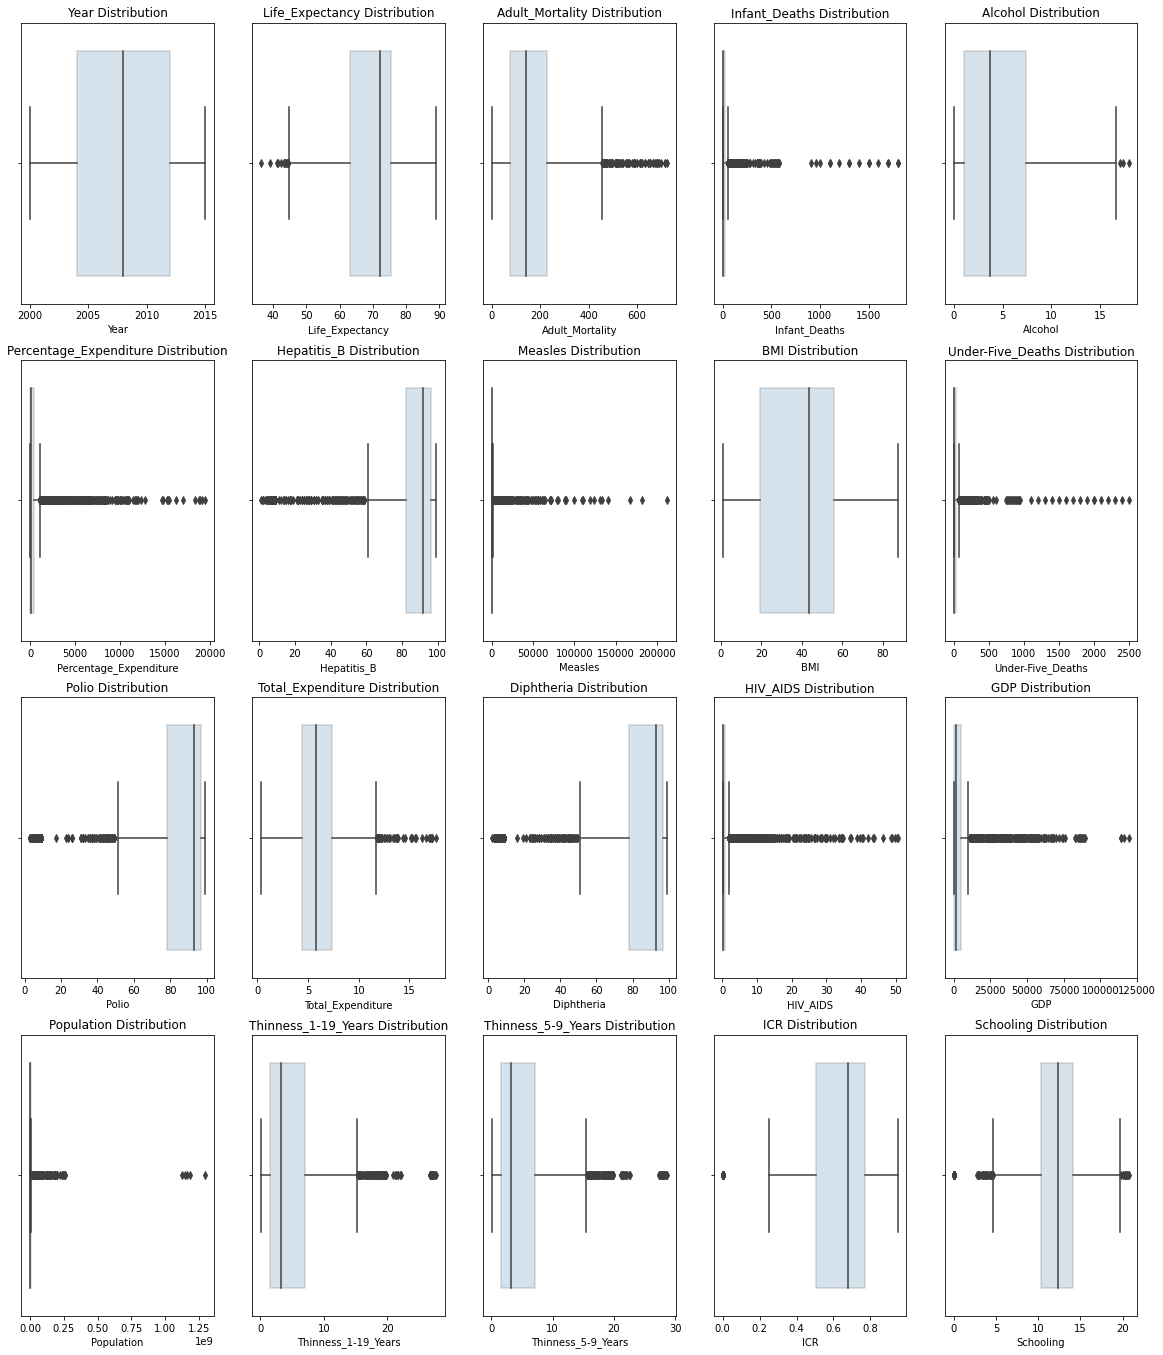

In [30]:
col=['Year','Life_Expectancy', 'Adult_Mortality',
       'Infant_Deaths', 'Alcohol', 'Percentage_Expenditure', 'Hepatitis_B',
       'Measles', 'BMI', 'Under-Five_Deaths', 'Polio', 'Total_Expenditure',
       'Diphtheria', 'HIV_AIDS', 'GDP', 'Population', 'Thinness_1-19_Years',
       'Thinness_5-9_Years', 'ICR', 'Schooling']
dic={}
#map an integer to each column value, which will be used in subplot selection
for i in range(len(col)):
    dic[col[i]]=i+1

    
plt.figure(figsize=(20,30))

for key,val in dic.items():
    plt.subplot(5,5,val)
    sns.boxplot(x=df[key],data=df,boxprops=dict(alpha=0.2))
    plt.xlabel(key)
    plt.title(key+' Distribution')

plt.show()

Feature Transformation :
Infant death,Adult mortality ,Measles -> find % of total population affected per country per year
we can use standardization to scale thing down<br>

compare mortality rate for Hepatitis_B,Measles,Diphtheria,HIV_AIDS using ANOVA <br>

We have less number of records so we just can't drop the outliers , we have to impute them to an acceptable range <br>


In [31]:
import scipy.stats as stats

def qq_plot(data):
    for col in data.columns.values:
        stats.probplot(data[col],dist='norm',plot=plt)
        plt.title('Q-Q plot for '+col)
    plt.show()

Here we're using qq_plot to check if Gaussian Transformation can give an almost normal distribution or not, we're trying these transformation - Thanks to [Krish Naik Feature Engineering](https://github.com/krishnaik06/Feature-Engineering-Live-sessions/blob/master/Feature%20Engineering-%20Normalization%20And%20Standardization-%20Day%205.ipynb)

1. logarithmic transformation
2. reciprocal transformation
3. square root transformation
4. exponential transformation (more general, you can use any exponent)
5. boxcox transformation (intentionally commented it as it modifies datafram , we've to remove that column later)


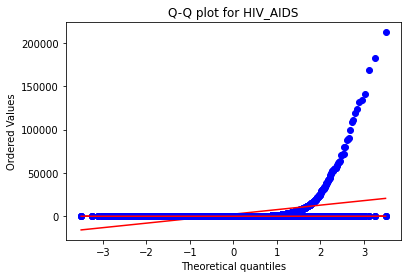

In [32]:
data=df[['Hepatitis_B','Measles','Diphtheria','HIV_AIDS']]
qq_plot(data)

None of them are normally distributed , one-way anova test will have type-1 error 

In [33]:
# from scipy.stats import f_oneway
# f_oneway(df['Hepatitis_B'],df['Measles'],df['Diphtheria'],df['HIV_AIDS'])
#F_onewayResult(statistic=90.43876694736144, pvalue=7.409267726887965e-58)

# **Now the most interesting part creating new features - How & Why ??** <br>
**Disease_Death** - Disease causing death , it doesn't matter what disease the effect is same for all of them so we can combine them into one feature , upon carefully reading Measles & HIV_AIDS are the 2 disease we're interested on<br>
1. According to data description sample was collected per 100 population , so we scale down to 100<br>
2. Still the value is high , so apply reciprocal transformation (since log is too small for that)<br>

**Mortality_Rate** - We have 3 potential candidate here - Adult_Mortality,Infant_Deaths,Under-Five_Deaths
Here the 1st question->  If infant(0-1) did cover under Under-Five_Deaths category why to put it on 1st place ?? <br>

Ans -> we don't know for sure , may be keeping track of birth-cirtificate is easier than death certificate but how do we deal with it ? <br>

Ans -> Upon looking at barplot we see a striking similarity between Infant_Deaths,Under-Five_Deaths so we can take any one, so for proper distribution = Adult_Mortality+Infant_Deaths-Under-Five_Deaths , then we do a scale down to per 100 population<br>

what if value becomes -ve so we take abs() -> till high do a square root (reduce a large amount ) -> now we need to reduce a small amount carefully (upon checking boxplot) we use log trasformation<br>

**Vaccination_Immunity** - we have Polio,Hepatitis_B,Diphtheria these are disease from mostly developing country where government expenditure is a big factor for eradicationg these viruses <br>

So we calculate how effeciently money is being used to vaccinate - <br> 
Numerator = vaccination rate , Denominator = avg. expenditure = (Gov. + personal) / 2 -> we smoothen the distribution by slightly shifting the tails using log transformation<br>


In [34]:
df['Disease_Death']=(df['Measles']+df['HIV_AIDS'])/10
df['Disease_Death']=1/df['Disease_Death']
df['Mortality_Rate']=df['Adult_Mortality']+df['Infant_Deaths']-df['Under-Five_Deaths']/10
df['Mortality_Rate']=np.log((df['Mortality_Rate'].abs())**(1/2))
df['Vaccination_Immunity']=np.log(2*(df['Polio']+df['Hepatitis_B']+df['Diphtheria'])/(df['Percentage_Expenditure']+df['Total_Expenditure']))

Schooling is an important factor for knowledge about hygiene & financial independence - Here values are too much skewed so 1st we apply log transformation then calculate Yearly costing for school . By doing so we can estimate a country with low GDP can afford schooling or not<br>

Don't replace 0 as log(1)=0 , so it's another reason to apply log transform 1st to avoid zero division error <br>

In [35]:
#df['Schooling']=df['Schooling'].replace(0,-1)
df['Yearly_Cost_Schooling']=np.log(df['Percentage_Expenditure']+df['Total_Expenditure'])/np.log(df['Schooling'])

Here both feature shows almost same property but distributon is a bit different , if we take difference we loose the variance in a certain range so we scale down (using log transformation) then take avg. to preserve the variance in mostly Under_Weight children range - **Under_weight child has more risk of dying than teenagers**<br>

In [36]:
df['Under_Weight']=(np.log(df['Thinness_1-19_Years'])+np.log(df['Thinness_5-9_Years']))/2

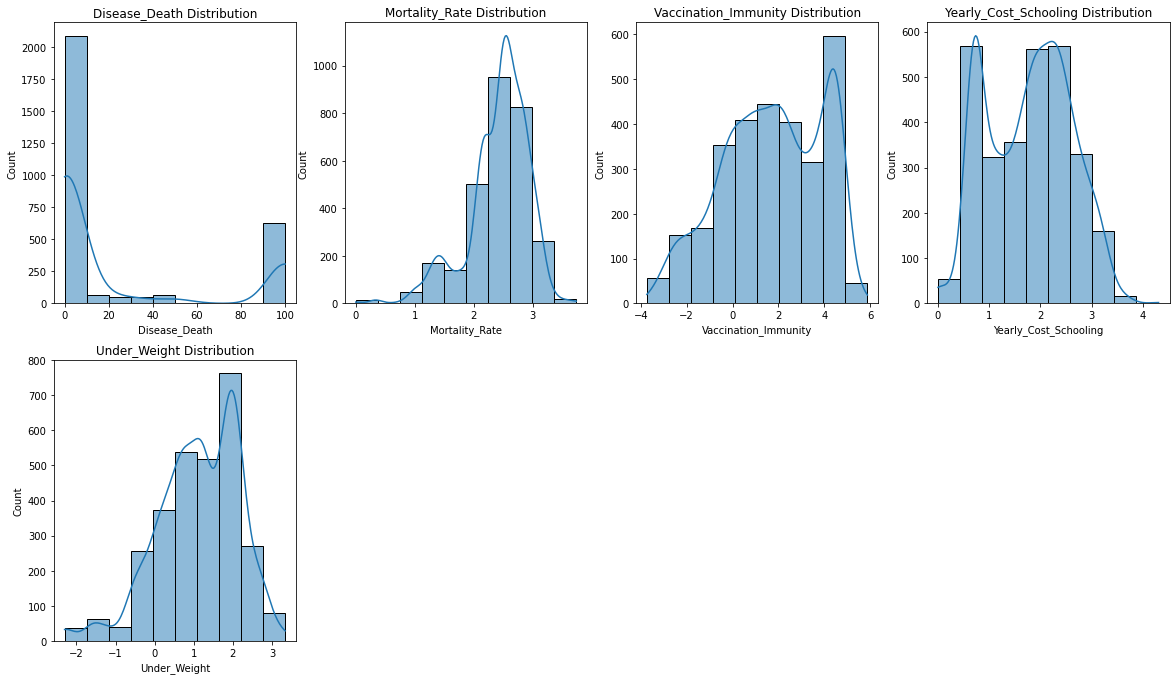

In [37]:
col=['Disease_Death','Mortality_Rate', 'Vaccination_Immunity','Yearly_Cost_Schooling','Under_Weight']
dic={}
for i in range(len(col)):
    dic[col[i]]=i+1

#set plot size
plt.figure(figsize=(20,30))

for key,val in dic.items():
    plt.subplot(5,4,val)
    sns.histplot(x=df[key],data=df,bins=10,kde=True)
    plt.xlabel(key)
    plt.title(key+' Distribution')

plt.show()

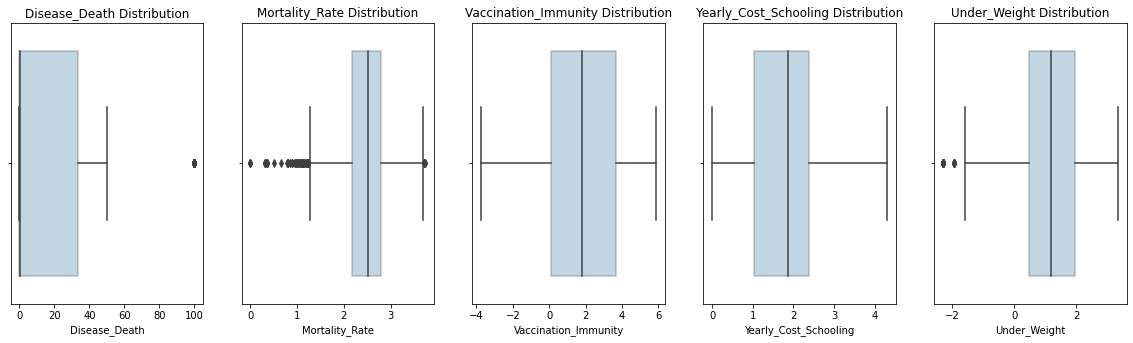

In [38]:
col=['Disease_Death','Mortality_Rate', 'Vaccination_Immunity','Yearly_Cost_Schooling','Under_Weight']
dic={}
for i in range(len(col)):
    dic[col[i]]=i+1
# Detect outliers in each variable using box plots.
plt.figure(figsize=(20,30))

for key,val in dic.items():
    plt.subplot(5,5,val)
    sns.boxplot(x=df[key],data=df,boxprops=dict(alpha=0.3))
    plt.xlabel(key)
    plt.title(key+' Distribution')

plt.show()

In [39]:
# adding extra measurement parameter
stats = df.describe()
stats.loc['median'] = df.median().tolist()
stats.loc['skew'] = df.skew().tolist()
stats.loc['kurt'] = df.kurtosis().tolist()
stats_df=pd.DataFrame(stats).reindex(['count','mean','std','median','50%','skew','kurt','min','max','25%','75%'])
stats_df 

,Year,Life_Expectancy,Adult_Mortality,Infant_Deaths,Alcohol,Percentage_Expenditure,Hepatitis_B,Measles,BMI,Under-Five_Deaths,Polio,Total_Expenditure,Diphtheria,HIV_AIDS,GDP,Population,Thinness_1-19_Years,Thinness_5-9_Years,ICR,Schooling,Disease_Death,Mortality_Rate,Vaccination_Immunity,Yearly_Cost_Schooling,Under_Weight
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.234717,164.725664,30.303948,4.546875,738.251295,83.022124,2419.592240,38.381178,42.035739,82.617767,5.924098,82.393125,1.742103,6611.523863,1.023085e+07,4.821886,4.852144,0.630362,12.009837,24.576720,2.426570,1.723566,1.776597,1.124057
std,4.613841,9.509115,124.086215,117.926501,3.921946,1987.914858,22.996984,11467.272489,19.935375,160.445548,23.367166,2.400770,23.655562,5.077785,13296.603449,5.402242e+07,4.397621,4.485854,0.205140,3.265139,40.418142,0.515665,2.155074,0.813180,1.043664
median,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.755000,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000,0.533519,2.520421,1.816999,1.864690,1.193922
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.755000,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000,0.533519,2.520421,1.816999,1.864690,1.193922
skew,-0.006409,-0.642391,1.177899,9.786963,0.649578,4.652051,-2.281697,9.441332,-0.229157,9.495065,-2.108909,0.661108,-2.083566,5.396112,3.543756,1.797284e+01,1.729496,1.795694,-1.212526,-0.635052,1.256995,-1.079126,-0.289091,-0.016866,-0.644404
kurt,-1.213722,-0.224081,1.766855,116.042756,-0.624913,26.573387,4.401205,114.859903,-1.270966,109.752795,3.827691,1.514132,3.608093,34.892008,15.143186,3.811342e+02,4.060346,4.453151,1.694067,1.123676,-0.308023,1.683799,-0.825995,-0.937888,0.412824
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000,0.000047,0.000000,-3.737677,-0.000000,-2.302585
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000,100.000000,3.742746,5.884740,4.305036,3.337420
25%,2004.000000,63.200000,74.000000,0.000000,1.092500,4.685343,82.000000,0.000000,19.400000,0.000000,78.000000,4.370000,78.000000,0.100000,580.486996,4.189172e+05,1.600000,1.600000,0.504250,10.300000,0.027617,2.178354,0.125377,1.036084,0.470004


So except for Disease_Deeath mean & std difference is very low , kurt & skew value is same , so our transformation did have a effect (we'll take care of that pesky right skewed Disease_Death later ;>)


In [40]:
df.columns

Index(['Country', 'Year', 'Status', 'Life_Expectancy', 'Adult_Mortality',
       'Infant_Deaths', 'Alcohol', 'Percentage_Expenditure', 'Hepatitis_B',
       'Measles', 'BMI', 'Under-Five_Deaths', 'Polio', 'Total_Expenditure',
       'Diphtheria', 'HIV_AIDS', 'GDP', 'Population', 'Thinness_1-19_Years',
       'Thinness_5-9_Years', 'ICR', 'Schooling', 'Disease_Death',
       'Mortality_Rate', 'Vaccination_Immunity', 'Yearly_Cost_Schooling',
       'Under_Weight'],
      dtype='object')

In [41]:
#drop unnecessary column
df.drop(['Country', 'Year', 'Status','Adult_Mortality','Infant_Deaths',
        'Percentage_Expenditure', 'Hepatitis_B',
       'Measles','Under-Five_Deaths', 'Polio', 'Total_Expenditure',
       'Diphtheria', 'HIV_AIDS', 'GDP', 'Population','Thinness_1-19_Years',
       'Thinness_5-9_Years','Schooling'],axis=1,inplace=True)

In [42]:
# using IQR method to find outliers & replacing ihem with lower_range , upper_range 
#since our dataset is small
def outlier_imputation(data):
    for col in data.columns.values:
        sorted(data[col])
        q1,q3=np.percentile(data,[25,75])
        iqr=q3-q1
        lower_range=q1-(1.5*iqr)
        upper_range=q3+(1.5*iqr)
        data[data[col]<lower_range]=lower_range
        data[data[col]>upper_range]=upper_range
    return data

In [43]:
df.columns

Index(['Life_Expectancy', 'Alcohol', 'BMI', 'ICR', 'Disease_Death',
       'Mortality_Rate', 'Vaccination_Immunity', 'Yearly_Cost_Schooling',
       'Under_Weight'],
      dtype='object')

In [44]:
df=outlier_imputation(df[['Alcohol', 'BMI', 'ICR',
       'Disease_Death', 'Mortality_Rate', 'Vaccination_Immunity',
       'Yearly_Cost_Schooling', 'Under_Weight']])

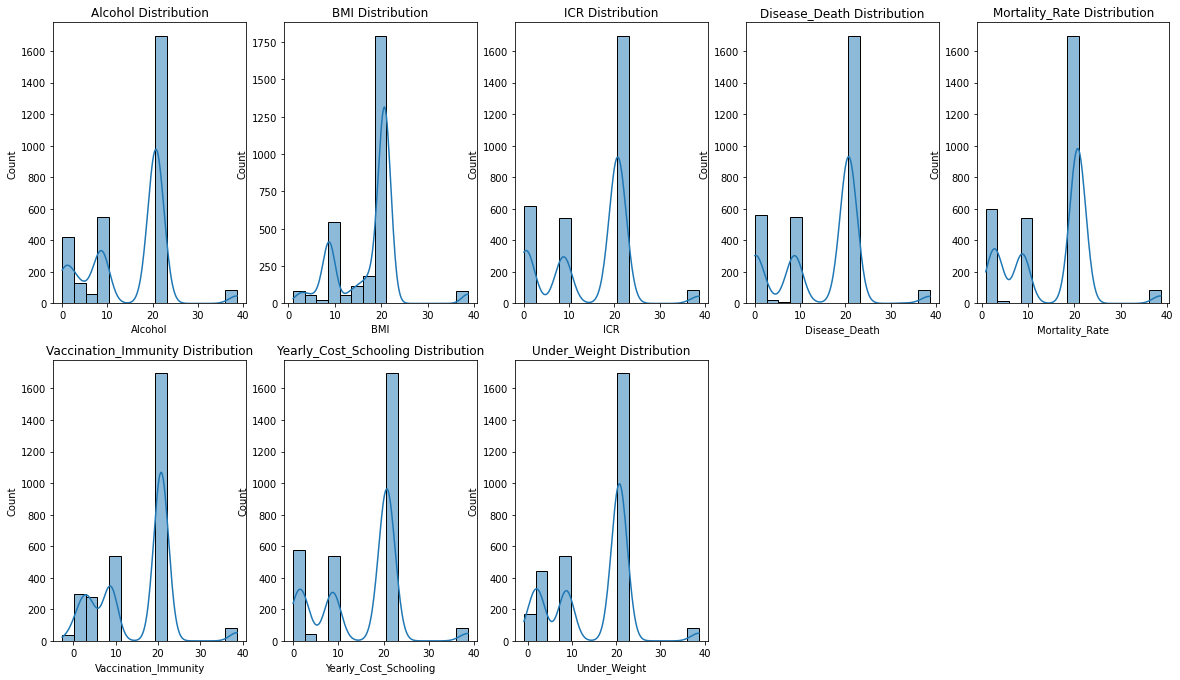

In [45]:
col=['Alcohol', 'BMI', 'ICR', 'Disease_Death',
       'Mortality_Rate', 'Vaccination_Immunity', 'Yearly_Cost_Schooling',
       'Under_Weight']
dic={}
for i in range(len(col)):
    dic[col[i]]=i+1
# Detect outliers in each variable using box plots.
plt.figure(figsize=(20,30))

for key,val in dic.items():
    plt.subplot(5,5,val)
    sns.histplot(x=df[key],data=df,bins=15,kde=True)
    plt.xlabel(key)
    plt.title(key+' Distribution')

plt.show()

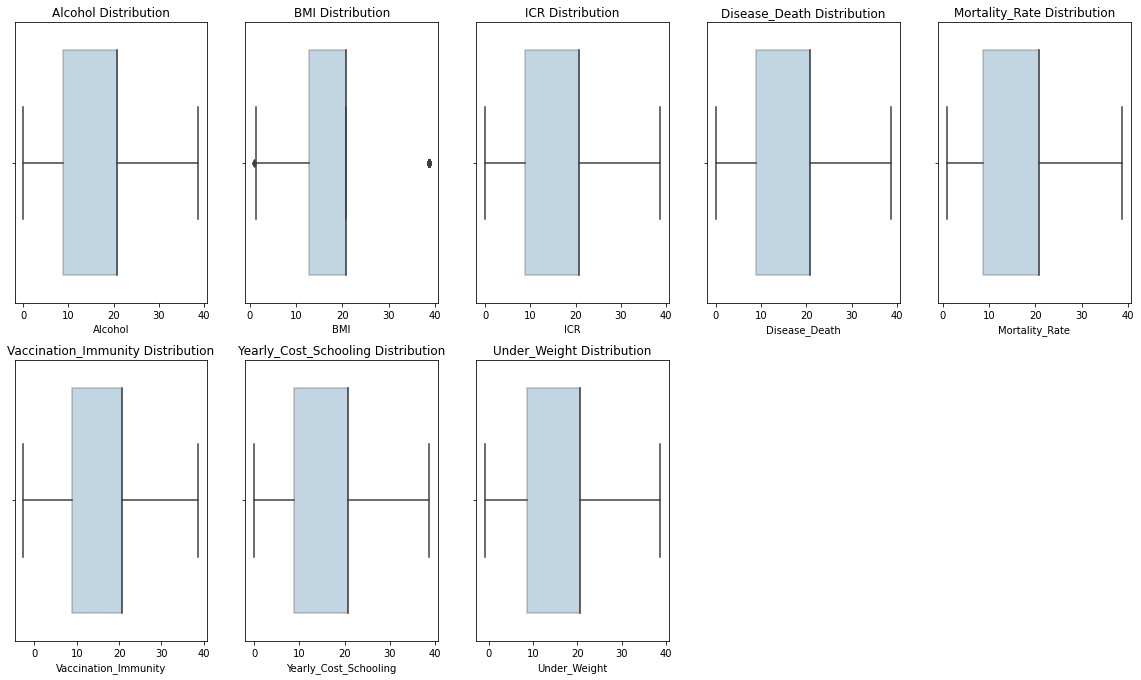

In [46]:
col=[ 'Alcohol', 'BMI', 'ICR', 'Disease_Death',
       'Mortality_Rate', 'Vaccination_Immunity', 'Yearly_Cost_Schooling',
       'Under_Weight']
dic={}
for i in range(len(col)):
    dic[col[i]]=i+1
# Detect outliers in each variable using box plots.
plt.figure(figsize=(20,30))

for key,val in dic.items():
    plt.subplot(5,5,val)
    sns.boxplot(x=df[key],data=df,boxprops=dict(alpha=0.3))
    plt.xlabel(key)
    plt.title(key+' Distribution')

plt.show()

Here our Regression model

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score,cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [48]:
df.isnull().sum()

Alcohol                  0
BMI                      0
ICR                      0
Disease_Death            0
Mortality_Rate           0
Vaccination_Immunity     0
Yearly_Cost_Schooling    0
Under_Weight             0
dtype: int64

In [49]:
#converting both of them to integer as float can be large value for Linear Regression
X=df.iloc[:,1:].astype('int')
Y=df.iloc[:,0].astype('int')

In [50]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=2)
lr = LinearRegression()
lr = lr.fit(X_train,Y_train)
Y_train_pred = lr.predict(X_train) #need for calculating train error
Y_test_pred = lr.predict(X_test)   #need for calculating test error
df_error = [] # store train & test error
df_error.append(pd.Series({'train': mean_squared_error(Y_train,Y_train_pred),
                           'test' : mean_squared_error(Y_test,Y_test_pred)}))
df_error

[train    0.898362
 test     0.702160
 dtype: float64]

R^2 - represents how much variance of the data is explained by the model, the R2=0.90 means that 0.10 of the variance can not explain by the model, the logical case when R^2=1 the model completely fit and explained all variance <br>

Cross-validation - primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data <br>

mean squared error or mean squared deviation of an estimator -  measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value. MSE is a risk function, corresponding to the expected value of the squared error loss. <br>

In [51]:
kf = KFold(shuffle=True,random_state=1,n_splits=10)
print(f"Cross-validated scores: {cross_val_score(lr,X,Y,cv=kf)}")
predictions = cross_val_predict(lr,X,Y,cv=kf)
print(f"Mean Square Error : {mean_squared_error(Y, predictions)}")
print(f"r2 Score(Cross-Predicted Accuracy) : {r2_score(Y, predictions)}")

Cross-validated scores: [0.9925726  0.98872758 0.98722044 0.98945496 0.99076799 0.98453851
 0.98692005 0.99126414 0.98475888 0.98729173]
Mean Square Error : 0.8757702125007297
r2 Score(Cross-Predicted Accuracy) : 0.9884558911912984


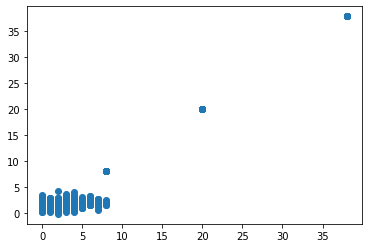

In [52]:
plt.scatter(Y,predictions)

So at last after all these steps we see our feature engineering in action - giving us more than 98% accuracy